<a href="https://colab.research.google.com/github/chipsalliance/silicon-notebooks/blob/main/xls-workshop-openlane-ja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XLSとOpenLaneを使ったコードからの半導体設計

```
Copyright 2021 Google LLC.
SPDX-License-Identifier: Apache-2.0
```
このノートブックでは
- 高位合成ツールキットの[XLS](https://google.github.io/xls/)での設計
- [OpenLane](https://github.com/The-OpenROAD-Project/OpenLane/)による、RTLからGDSの生成
- オープンソースの[SKY130](https://github.com/google/skywater-pdk/) PDK向けのチップ設計

を取り扱います。ソフトウェア開発に近い形でのハードウェア設計を体験してみましょう。

In [1]:
%pip install -q https://github.com/conda-incubator/condacolab/archive/28521d7c5c494dd6377bb072d97592e30c44609c.tar.gz
#@title conda環境のインストール {display-mode: "form"}
#@markdown - ▷ ボタンをクリックすると、conda-edaのセットアップが開始されます。
#@markdown - Click the ▷ button to setup the digital design environment based on [conda-eda](https://github.com/hdl/conda-eda).

openlane_version = 'latest' #@param {type:"string"}
open_pdks_version = 'latest' #@param {type:"string"}
xls_version = 'latest' #@param {type:"string"}

if openlane_version == 'latest':
  openlane_version = ''
if open_pdks_version == 'latest':
  open_pdks_version = ''
if xls_version == 'latest':
  xls_version = ''

import os
import pathlib
import sys

!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
site_package_path = conda_prefix_path / 'lib/python3.7/site-packages'
sys.path.append(str(site_package_path.resolve()))
CONDA_PREFIX = str(conda_prefix_path.resolve())
PATH = os.environ['PATH']
LD_LIBRARY_PATH = os.environ.get('LD_LIBRARY_PATH', '')
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}
%env LD_LIBRARY_PATH={CONDA_PREFIX}/lib:{LD_LIBRARY_PATH}
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!CI=0 bin/micromamba install --quiet --yes --prefix $CONDA_PREFIX \
                     --channel litex-hub \
                     --channel main \
                     openlane={openlane_version} \
                     open_pdks.sky130a={open_pdks_version} \
                     xls={xls_version}
!curl -L -O https://patch-diff.githubusercontent.com/raw/The-OpenROAD-Project/OpenLane/pull/1503.patch
!patch -p1 -d conda-env/share/openlane < 1503.patch
!curl -L -O https://github.com/google/xls/archive/refs/heads/main.tar.gz
!tar --strip-components=1 -xf main.tar.gz xls-main/xls/dslx/stdlib/ xls-main/xls/modules/
def2gds_mag = '''gds read $::env(CONDA_PREFIX)/share/pdk/sky130A/libs.ref/sky130_fd_sc_hd/gds/sky130_fd_sc_hd.gds
lef read $::env(CONDA_PREFIX)/share/pdk/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef
lef read $::env(CONDA_PREFIX)/share/pdk/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef
def read $::env(IN_DEF)
gds write $::env(IN_DEF).gds'''
with open('def2gds.mag', 'w') as f:
  f.write(def2gds_mag)
!git clone https://github.com/mbalestrini/GDS2glTF.git
!python -m pip install -r GDS2glTF/requirements.txt
!git clone https://github.com/proppy/gds_viewer.git
import jinja2
gds_viewer = jinja2.Environment(loader=jinja2.FileSystemLoader('gds_viewer')).get_template('viewer.html') 

     - 35 kB 5.3 MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
env: CONDA_PREFIX=/content/conda-env
env: PATH=/content/conda-env/bin:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin
env: LD_LIBRARY_PATH=/content/conda-env/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64

                                           __
          __  ______ ___  ____ _____ ___  / /_  ____ _
         / / / / __ `__ \/ __ `/ __ `__ \/ __ \/ __ `/
        / /_/ / / / / / / /_/ / / / / / / /_/ / /_/ /
       / .___/_/ /_/ /_/\__,_/_/ /_/ /_/_.___/\__,_/
      /_/

Empty environment created at prefix: /content/conda-env
  Package                             Version  Build                 Channel                 Size
───────────────────────────────────────────────────────────────────────────────────────────────────
  Insta

## 高位合成(HLS)を使った設計

[XLS](https://google.github.io/xls/)は高位合成(High Level Synthesis: HLS)のツールチェインを提供します。XLSを用いることで、ソフトウェア開発に近い方法でハードウェアの設計が可能です。

[DSLX](https://google.github.io/xls/dslx_reference/) はハードウェア設計向けのデータフロー志向・関数型のドメイン特化言語(Domain Specific Language: DSL)です。DSLXで記述した高レベルな機能の設計から、具体的なハードウェアデザインを生成できます。

![img](https://google.github.io/xls/images/xls_stack_diagram.png)

### DSLX

以下の例を通して次のようなDSLXの機能を紹介します。
- 基本的な言語仕様と[文法](https://google.github.io/xls/dslx_reference/#expressions)
- [ユニットテスト](https://google.github.io/xls/dslx_reference/#unit-tests)
- [パラメトリックな関数](https://google.github.io/xls/dslx_reference/#parametric-functions)の定義
- [標準ライブラリ](https://google.github.io/xls/dslx_std/)とモジュールの[インポート](https://google.github.io/xls/dslx_reference/#imports).


In [2]:
%%bash -c 'cat > user_module.x; interpreter_main user_module.x'

// 最初の行では、"adder1" という名前の関数 (fn) を宣言している (Functions: https://google.github.io/xls/dslx_reference/#functions)
// この関数は "a" と "b" という 2 つの 1 ビット符号なし整数 (u1) を受け取り、2 ビット符号なし整数 (u2) を返す
// この例では、"-> u2"の部分を削除することで、戻り値のない関数を定義することもできる

// 2行目は "n" という名前の2ビット符号なし整数（u2）を定義し、"a" と "b" の和を代入している
// "let" ステートメントで新しい変数を導入する
// "as" でu1型変数 "a" をu2型変数に変換（Type cast：https://google.github.io/xls/dslx_reference/#type-casting）

// 3行目は戻り値(関数は最後に計算した式の結果を戻り値として返す)

fn adder1(a: u1, b: u1) -> u2 {
  let n: u2 = a as u2 + b as u2;
  n
}


// "adder1"の関数を8ビット入力8ビット出力に変換する関数
// ビットの抽出("io_in[0:1]")についてはDSLX referenceの "Bit slice expressions" 項を参照（Bit slice expressions：https://google.github.io/xls/dslx_reference/#bit-slice-expressions）

fn user_module(io_in: u8) -> u8 {
  adder1(io_in[0:1], io_in[4:5]) as u8
}


// 関数が意図したとおりに動作するかをテストするtest function
// DSLX referenceの "assert_eq, assert_lt" 項を参照（assert_eq, assert_lt: https://google.github.io/xls/dslx_reference/#assert_eq-assert_lt）
// "let _ = ..."部分のアンダースコア(_)は、その関数の戻り値を無視することを意味する
// バイナリ値("0b0001_0001")のアンダースコア(_)は可読性のために挿入されているだけなので無視してもOK

#[test]
fn test() {
  let _ = assert_eq(adder1(u1:0b1, u1:0b1), u2:0b10);
  let _ = assert_eq(user_module(u8:0b0001_0001), u8:0b000000_10);
  _
}

[ RUN UNITTEST  ] test
[            OK ]
[===============] 1 test(s) ran; 0 failed; 0 skipped.


## ハードウェアIRへの変換
DSLXのコードからハードウェア回路合成により適した形式
[XLS IR](https://google.github.io/xls/ir_semantics/)に変換しましょう。
XLS IRは回路合成に特化した純粋なデータフロー志向の中間表現(Intermediate Respresentation: IR)です。

In [3]:
!ir_converter_main --top=user_module user_module.x > user_module.ir
!opt_main user_module.ir > user_module_opt.ir
!cat user_module_opt.ir

package user_module

file_number 0 "fake_file.x"

top fn __user_module__user_module(io_in: bits[8]) -> bits[8] {
  literal.17: bits[1] = literal(value=0, id=17, pos=[(0,7,8)])
  bit_slice.7: bits[1] = bit_slice(io_in, start=0, width=1, id=7, pos=[(0,7,14)])
  literal.21: bits[1] = literal(value=0, id=21, pos=[(0,7,8)])
  bit_slice.8: bits[1] = bit_slice(io_in, start=4, width=1, id=8, pos=[(0,7,26)])
  concat.18: bits[2] = concat(literal.17, bit_slice.7, id=18, pos=[(0,7,8)])
  concat.19: bits[2] = concat(literal.21, bit_slice.8, id=19, pos=[(0,7,8)])
  literal.15: bits[6] = literal(value=0, id=15)
  n: bits[2] = add(concat.18, concat.19, id=20, pos=[(0,2,22)])
  ret concat.16: bits[8] = concat(literal.15, n, id=16)
}


## RTLの生成

XLS codegenを使うことで、XLS IRから回路合成とシミュレーションに使用する
(System) Verilog [RTL](https://en.wikipedia.org/wiki/Register-transfer_level)を生成できます。

[Verilog](https://en.wikipedia.org/wiki/Verilog)は回路設計で広く用いられているので、XLSで生成されたVerilogコードは、各種の設計フローや他の設計と統合することができます。

In [4]:
!codegen_main --use_system_verilog=false --module_name=user_module --generator=combinational user_module_opt.ir > user_module.v
!cat user_module.v

module user_module(
  input wire [7:0] io_in,
  output wire [7:0] out
);
  wire [1:0] n;
  assign n = {1'h0, io_in[0]} + {1'h0, io_in[4]};
  assign out = {6'h00, n};
endmodule


## OpenLaneフローの実行

[OpenLane](https://openlane.readthedocs.io/en/latest/)
は[RTL](https://en.wikipedia.org/wiki/Register-transfer_level) 
から
[GDSII](https://en.wikipedia.org/wiki/GDSII)
を生成する自動化されたフローです。

このフローは
[OpenROAD](https://theopenroadproject.org/), 
[Yosys](https://yosyshq.net/yosys/), [Magic](http://www.opencircuitdesign.com/magic/), [Netgen](http://opencircuitdesign.com/netgen/)
といったコンポーネントと
[open source PDKs](https://github.com/google/open-source-pdks)向けのデザイン探索や最適化のためのカスタムスクリプトからなります。

フローの概要については下記の図を参考にしてください。

![img](https://openlane.readthedocs.io/en/latest/_images/flow_v1.png)

#### OpenLaneの設定

[ドキュメント](https://openlane.readthedocs.io/en/latest/reference/configuration.html)

In [5]:
%%writefile config.json
{
    "DESIGN_NAME": "user_module",
    "VERILOG_FILES": "dir::user_module.v",
    "CLOCK_TREE_SYNTH": false,
    "CLOCK_PERIOD": 10,
    "CLOCK_PORT": "clk",
    "CLOCK_NET": "ref::$CLOCK_PORT",
    "FP_SIZING": "absolute",
    "DIE_AREA": "0 0 50 50",
    "PL_TARGET_DENSITY": 0.30,
    "FP_PIN_ORDER_CFG": "dir::pin_order.cfg"
}

Writing config.json


In [6]:
%%writefile pin_order.cfg
#BUS_SORT

#W
io_in.*

#E
out.*

Writing pin_order.cfg


### 回路合成

- 入力: [RTL](https://en.wikipedia.org/wiki/Register-transfer_level) (Verilog)
- 出力: 素子情報付きの[ネットリスト](https://en.wikipedia.org/wiki/Netlist) (Verilog)
- メトリック: セルの数と [タイミング収束](https://en.wikipedia.org/wiki/Timing_closure) の推定値

[ドキュメント](https://openlane.readthedocs.io/en/latest/usage/hardening_macros.html#synthesis)

In [7]:
%env PDK=sky130A
!flow.tcl -design . -to synthesis

env: PDK=sky130A
OpenLane 2022.11.12_3_g1298859-conda
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[WARNING]: OpenLane may not function properly: not enough values to unpack (expected 3, got 1)
The version of open_pdks used in building the PDK does not match the version OpenLane was tested on (installed: a519523b0d9bc913a6f87a5eed083597ed9e2e93, tested: 0059588eebfc704681dc2368bd1d33d96281d10f)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
The version of magic used in building the PDK does not match the version OpenLane was tested on (installed: f0668447616c071f145d3d3fa1dfde9762b62b7b, tested: 94daf986ab9aa94a9ae2ac3539fa5def9bd2a1ac)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
[INFO]: Using configuration in 'config.json'...
[INFO]: PDK Root: /content/conda-env/share/pdk
[INFO]:

[PosixPath('runs/RUN_2022.11.21_01.37.27/tmp/synthesis/post_techmap.dot')]


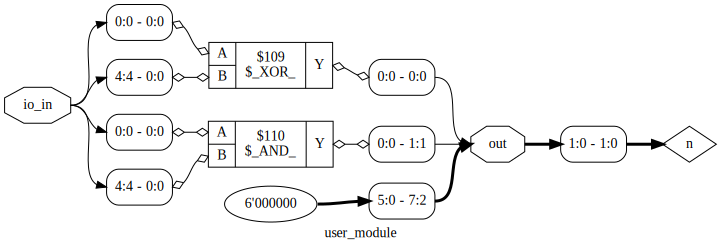

In [8]:
#@title ネットリストのプレビュー {display-mode: "form"}

import graphviz
import pathlib

dots = sorted(pathlib.Path('runs').glob('*/tmp/synthesis/post_techmap.dot'))
print(dots)
dot = graphviz.Source.from_file(dots[-1])
dot.engine = 'dot'
dot

### フロアプラン

- 入力: 素子情報付きの[ネットリスト](https://en.wikipedia.org/wiki/Netlist) (Verilog)
- 出力: 電源供給配線網(Power Delivery Network: PDN)とI/Oピンのついたダイ上のレイアウト([DEF](https://en.wikipedia.org/wiki/Design_Exchange_Format))
- メトリック: コアの面積

[ドキュメント](https://openlane.readthedocs.io/en/latest/usage/hardening_macros.html#floorplan)

In [9]:
%env PDK=sky130A
!flow.tcl -design . -to floorplan

env: PDK=sky130A
OpenLane 2022.11.12_3_g1298859-conda
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[WARNING]: OpenLane may not function properly: not enough values to unpack (expected 3, got 1)
The version of open_pdks used in building the PDK does not match the version OpenLane was tested on (installed: a519523b0d9bc913a6f87a5eed083597ed9e2e93, tested: 0059588eebfc704681dc2368bd1d33d96281d10f)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
The version of magic used in building the PDK does not match the version OpenLane was tested on (installed: f0668447616c071f145d3d3fa1dfde9762b62b7b, tested: 94daf986ab9aa94a9ae2ac3539fa5def9bd2a1ac)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
[INFO]: Using configuration in 'config.json'...
[INFO]: PDK Root: /content/conda-env/share/pdk
[INFO]:

In [10]:
#@title プレビュー {display-mode: "form"}

import pathlib

STEP='floorplan'
in_def = sorted(pathlib.Path('runs').glob(f'*/results/{STEP}/*.def'))[-1].resolve()
!IN_DEF={in_def} magic -dnull -noconsole -rcfile {CONDA_PREFIX}/share/pdk/sky130A/libs.tech/magic/sky130A.magicrc < def2gds.mag
!python3 GDS2glTF/gds2gltf.py {in_def}.gds | tee gds2gltf.log
import IPython.display
IPython.display.clear_output(wait=True)
with open(f'{in_def}.gds.gltf') as f:
  gltf_data=f.read()
  output = gds_viewer.render(gltf_data=gltf_data)
IPython.display.HTML(output)

### 配置

- 入力: 素子情報付きの[ネットリスト](https://en.wikipedia.org/wiki/Netlist) (Verilog), 
PDNとI/Oピンつきのダイの物理レイアウト([DEF](https://en.wikipedia.org/wiki/Design_Exchange_Format))
- 出力: コンポーネントのセルが配置された物理レイアウト ([DEF](https://en.wikipedia.org/wiki/Design_Exchange_Format))
- メトリック: コア面積, セル密度, [タイミング収束](https://en.wikipedia.org/wiki/Timing_closure)の推定値

[ドキュメント](https://openlane.readthedocs.io/en/latest/usage/hardening_macros.html#placement)

In [11]:
%env PDK=sky130A
!flow.tcl -design . -to placement

env: PDK=sky130A
OpenLane 2022.11.12_3_g1298859-conda
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[WARNING]: OpenLane may not function properly: not enough values to unpack (expected 3, got 1)
The version of open_pdks used in building the PDK does not match the version OpenLane was tested on (installed: a519523b0d9bc913a6f87a5eed083597ed9e2e93, tested: 0059588eebfc704681dc2368bd1d33d96281d10f)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
The version of magic used in building the PDK does not match the version OpenLane was tested on (installed: f0668447616c071f145d3d3fa1dfde9762b62b7b, tested: 94daf986ab9aa94a9ae2ac3539fa5def9bd2a1ac)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
[INFO]: Using configuration in 'config.json'...
[INFO]: PDK Root: /content/conda-env/share/pdk
[INFO]:

In [12]:
#@title プレビュー {display-mode: "form"}

import pathlib

STEP='placement'
in_def = sorted(pathlib.Path('runs').glob(f'*/results/{STEP}/*.def'))[-1].resolve()
!IN_DEF={in_def} magic -dnull -noconsole -rcfile {CONDA_PREFIX}/share/pdk/sky130A/libs.tech/magic/sky130A.magicrc < def2gds.mag
!python3 GDS2glTF/gds2gltf.py {in_def}.gds | tee gds2gltf.log
import IPython.display
IPython.display.clear_output(wait=True)
with open(f'{in_def}.gds.gltf') as f:
  gltf_data=f.read()
  output = gds_viewer.render(gltf_data=gltf_data)
IPython.display.HTML(output)

### 配線

- 入力: 素子情報付きの[ネットリスト](https://en.wikipedia.org/wiki/Netlist) (Verilog), 
コンポーネントのセルが配置された物理レイアウト([DEF](https://en.wikipedia.org/wiki/Design_Exchange_Format))

- 出力: コンポーネントのセルへの配線が完了した物理レイアウト ([DEF](https://en.wikipedia.org/wiki/Design_Exchange_Format))
- メトリック: ルートの衝突, [タイミング収束](https://en.wikipedia.org/wiki/Timing_closure)の予測値

[ドキュメント](https://openlane.readthedocs.io/en/latest/usage/hardening_macros.html#routing)

In [13]:
%env PDK=sky130A
!flow.tcl -design . -to routing

env: PDK=sky130A
OpenLane 2022.11.12_3_g1298859-conda
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[WARNING]: OpenLane may not function properly: not enough values to unpack (expected 3, got 1)
The version of open_pdks used in building the PDK does not match the version OpenLane was tested on (installed: a519523b0d9bc913a6f87a5eed083597ed9e2e93, tested: 0059588eebfc704681dc2368bd1d33d96281d10f)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
The version of magic used in building the PDK does not match the version OpenLane was tested on (installed: f0668447616c071f145d3d3fa1dfde9762b62b7b, tested: 94daf986ab9aa94a9ae2ac3539fa5def9bd2a1ac)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
[INFO]: Using configuration in 'config.json'...
[INFO]: PDK Root: /content/conda-env/share/pdk
[INFO]:

In [14]:
#@title プレビュー {display-mode: "form"}

import pathlib

STEP='routing'
in_def = sorted(pathlib.Path('runs').glob(f'*/results/{STEP}/*.def'))[-1].resolve()
!IN_DEF={in_def} magic -dnull -noconsole -rcfile {CONDA_PREFIX}/share/pdk/sky130A/libs.tech/magic/sky130A.magicrc < def2gds.mag
!python3 GDS2glTF/gds2gltf.py {in_def}.gds | tee gds2gltf.log
import IPython.display
IPython.display.clear_output(wait=True)
with open(f'{in_def}.gds.gltf') as f:
  gltf_data=f.read()
  output = gds_viewer.render(gltf_data=gltf_data)
IPython.display.HTML(output)

### サインオフ

- 入力: コンポーネントのセルへの配線が完了した物理レイアウト([DEF](https://en.wikipedia.org/wiki/Design_Exchange_Format))
- 出力: ファウンドリの[DRCルール](https://en.wikipedia.org/wiki/Design_rule_checking), 検証済みで製造に出せる物理レイアウト ([GDSII](https://en.wikipedia.org/wiki/GDSII))
- メトリック: DRCエラー, [寄生データ](https://en.wikipedia.org/wiki/Standard_Parasitic_Exchange_Format), [タイミング収束](https://en.wikipedia.org/wiki/Timing_closure)の予測値

[ドキュメント](https://openlane.readthedocs.io/en/latest/usage/hardening_macros.html#final-reports-and-checks)

In [15]:
%env PDK=sky130A
!flow.tcl -design .

env: PDK=sky130A
OpenLane 2022.11.12_3_g1298859-conda
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[WARNING]: OpenLane may not function properly: not enough values to unpack (expected 3, got 1)
The version of open_pdks used in building the PDK does not match the version OpenLane was tested on (installed: a519523b0d9bc913a6f87a5eed083597ed9e2e93, tested: 0059588eebfc704681dc2368bd1d33d96281d10f)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
The version of magic used in building the PDK does not match the version OpenLane was tested on (installed: f0668447616c071f145d3d3fa1dfde9762b62b7b, tested: 94daf986ab9aa94a9ae2ac3539fa5def9bd2a1ac)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
[INFO]: Using configuration in 'config.json'...
[INFO]: PDK Root: /content/conda-env/share/pdk
[INFO]:

In [16]:
#@title プレビュー {display-mode: "form"}

import pathlib

gds = sorted(pathlib.Path('runs').glob(f'*/results/final/gds/*.gds'))[-1].resolve()
!python3 GDS2glTF/gds2gltf.py {gds} | tee gds2gltf.log
import IPython.display
IPython.display.clear_output(wait=True)
with open(f'{gds}.gltf') as f:
  gltf_data=f.read()
  output = gds_viewer.render(gltf_data=gltf_data)
IPython.display.HTML(output)

In [17]:
#@title メトリック {display-mode: "form"}
#@markdown [ドキュメント](https://openlane.readthedocs.io/en/latest/reference/datapoint_definitions.html)
import pathlib
import pandas as pd

pd.options.display.max_rows = None
csv = sorted(pathlib.Path('runs').glob('*/reports/metrics.csv'))
df = pd.read_csv(csv[-1])
df.transpose()

,0
design,/content
design_name,user_module
config,RUN_2022.11.21_01.38.14
flow_status,flow completed
total_runtime,0h0m29s0ms
routed_runtime,0h0m16s0ms
(Cell/mm^2)/Core_Util,7200.0
DIEAREA_mm^2,0.0025
CellPer_mm^2,3600.0
OpenDP_Util,5.21


## テープアウト

Googleのスポンサーする[OpenMPW shuttle program](https://developers.google.com/silicon)に参加するためには、設計したチップデザインを[Caravel SoC harness](https://caravel-harness.readthedocs.io/)と統合する必要があります。

[Caravel User Project](https://caravel-user-project.readthedocs.io/en/latest/)
のテンプレートを使用して、[mpw pre-check](https://github.com/efabless/mpw_precheck)のテストが通ることを確認してください。

![caravel](https://caravel-user-project.readthedocs.io/en/latest/_static/layout.png)

- ユーザープロジェクトの面積: 2920 µm x 3520 µm
- SoC: RISC-V based ([specs](https://caravel-mgmt-soc-litex.readthedocs.io/en/latest/#features))
- I/O ピン: 38 ([pinout](https://caravel-harness.readthedocs.io/en/latest/pinout.html))
- 通信: Wishbone bus and 128 logic analyser pins


# 演習課題

### ⌨ DSLX

1. 以下の関数 `mul4` を変更して4ビットの乗算器を実装してください。実装にあたっては、[DSLXのスタンダードライブラリ](https://google.github.io/xls/dslx_std/) の関数を使ってみましょう（`std::`のプレフィックスを忘れずに）。
1. この乗算器のVerilogコードを生成してください。
1. OpenLaneのフローを走らせて回路合成まで進めてください。
1. グラフの複雑さを加算器と比較してみてください。

In [ ]:
%%bash -c 'cat > user_module.x; interpreter_main user_module.x'
import std

fn mul4(a: u4, b: u4) -> u8 {
  u8:0 // TODO(YOU) implement mul4
}

fn user_module(io_in: u8) -> u8 {
  mul4(io_in[0:4], io_in[4:8]) as u8
}

#[test]
fn test() {
  let _ = assert_eq(mul4(u4:8, u4:8), u8:64);
  let _ = assert_eq(user_module(u8:0b1000_1000), u8:0b0100_0000);
  _
}

In [ ]:
!ir_converter_main --top=user_module user_module.x > user_module.ir
!opt_main user_module.ir > user_module_opt.ir
!codegen_main --use_system_verilog=false --module_name=user_module --generator=combinational user_module_opt.ir > user_module.v
!cat user_module.v

In [ ]:
%env PDK=sky130A
!flow.tcl -design . -to synthesis

In [ ]:
#@title プレビュー {display-mode: "form"}

import graphviz
import pathlib

dots = sorted(pathlib.Path('runs').glob('*/tmp/synthesis/post_techmap.dot'))
dot = graphviz.Source.from_file(dots[-1])
dot.engine = 'dot'
dot

### 🛠️ OpenLane

1. OpenLaneのフローを最後まで走らせてください。
1. `DIE_AREA`または`PL_TARGET_DENSITY` の[設定値](https://openlane.readthedocs.io/en/latest/reference/configuration.html)を変更することでエラーが発生しないように調整してください。
1. [メトリック](https://openlane.readthedocs.io/en/latest/reference/datapoint_definitions.html) (`Total_Physical_Cells`, `wire_length`)を加算器の場合と比較してください。
1. レイアウトを加算器の場合と比較してください。

In [ ]:
%%writefile config.json
{
    "DESIGN_NAME": "user_module",
    "VERILOG_FILES": "dir::user_module.v",
    "CLOCK_TREE_SYNTH": false,
    "CLOCK_PERIOD": 10,
    "CLOCK_PORT": "clk",
    "CLOCK_NET": "ref::$CLOCK_PORT",
    "FP_SIZING": "absolute",
    "DIE_AREA": "0 0 50 50",
    "PL_TARGET_DENSITY": 0.30,
    "FP_PIN_ORDER_CFG": "dir::pin_order.cfg"
}

In [ ]:
%env PDK=sky130A
!flow.tcl -design .

In [ ]:
#@title メトリック {display-mode: "form"}
import pathlib
import pandas as pd

pd.options.display.max_rows = None
csv = sorted(pathlib.Path('runs').glob('*/reports/metrics.csv'))
df = pd.read_csv(csv[-1])
df.transpose()

In [ ]:
#@title プレビュー {display-mode: "form"}

import pathlib

gds = sorted(pathlib.Path('runs').glob(f'*/results/final/gds/*.gds'))[-1].resolve()
!python3 GDS2glTF/gds2gltf.py {gds} | tee gds2gltf.log
import IPython.display
IPython.display.clear_output(wait=True)
with open(f'{gds}.gltf') as f:
  gltf_data=f.read()
  output = gds_viewer.render(gltf_data=gltf_data)
IPython.display.HTML(output)